In [108]:
import re
import pandas as pd
from datetime import datetime
from transformers import pipeline
import matplotlib.pyplot as plt

In [109]:
POC_NAME = "TADA ALBORADA"


In [110]:
ruta_archivo = './chats/alborada.txt'

In [111]:
patron_linea = re.compile(
    r'^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)$'
)

In [112]:
datos = []
ultima_fecha = None
ultima_hora = None
ultima_persona = None
ultimo_mensaje = []

In [113]:
with open(ruta_archivo, 'r', encoding='utf-8') as f:
    for linea in f:
        linea = linea.strip()

        match = patron_linea.match(linea)
        if match:
            # Si hay un mensaje anterior sin cerrar, lo guardamos
            if ultima_fecha and ultima_persona is not None:
                datos.append([
                    ultima_fecha,
                    ultima_hora,
                    ultima_persona,
                    "\n".join(ultimo_mensaje)
                ])

            # Extraemos datos de la nueva línea
            fecha_str = match.group(1)  # "DD/MM/YYYY"
            hora_str = match.group(2)  # "HH:MM"
            persona = match.group(3)
            mensaje = match.group(4)

            # Convertimos a datetime
            try:
                fecha_hora = datetime.strptime(
                    f"{fecha_str} {hora_str}",
                    "%d/%m/%Y %H:%M"
                )
            except ValueError:
                # Si falla el parseo, podemos ignorar la línea o manejarla
                continue

            # Guardamos temporalmente para multiline
            ultima_fecha = fecha_hora.date()
            ultima_hora = fecha_hora.time()
            ultima_persona = persona
            ultimo_mensaje = [mensaje]

        else:
            # Es la continuación (siguiente línea) del mensaje anterior
            if ultima_persona is not None:
                ultimo_mensaje.append(linea)

# Agregamos el último mensaje si quedó pendiente
if ultima_fecha and ultima_persona is not None:
    datos.append([
        ultima_fecha,
        ultima_hora,
        ultima_persona,
        "\n".join(ultimo_mensaje)
    ])

In [114]:
# ==========================================================================
# 2. Construir DataFrame completo de todos los chats
# ==========================================================================
df_chats = pd.DataFrame(datos, columns=['Fecha', 'Hora', 'Persona', 'Mensaje'])

# Creamos una columna de tipo datetime completa
df_chats['FechaHora'] = df_chats.apply(
    lambda x: datetime.combine(x['Fecha'], x['Hora']), axis=1
)

# Ordenamos el DataFrame por fecha-hora por si no viniese ordenado
df_chats.sort_values(by='FechaHora', inplace=True, ignore_index=True)

In [115]:
# ==========================================================================
# 3. DataFrame con integrantes únicos (df_integrantes)
# ==========================================================================
integrantes_unicos = df_chats['Persona'].unique().tolist()
df_integrantes = pd.DataFrame({'Integrante': integrantes_unicos})

In [116]:
# ==========================================================================
# 4. Identificación de asesores
# ==========================================================================
# Paso 1: Detectar usuarios que enviaron la frase clave
asesores = df_chats[df_chats['Mensaje'].str.contains(
    "Me pongo a sus órdenes", case=False, na=False
)]['Persona'].unique()

# Paso 2: Crear una nueva columna `EsAsesor`
df_chats['EsAsesor'] = df_chats['Persona'].isin(asesores)

In [117]:
# ==========================================================================
# 5. DataFrame con chats filtrados (df_chats_filtrados)
#    Reglas:
#      - Incluir TADA ALBORADA (tienda).
#      - Incluir asesores en todos sus mensajes.
#      - Excluir el resto.
# ==========================================================================
def es_tienda(row):
    return "TADA ALBORADA" in row['Persona'].upper()

def cambiar_nombre_tienda(row):
    return "TIENDA" if POC_NAME in row['Persona'].upper() else row['Persona']

# Filtro de tienda o asesores
df_chats_filtrados = df_chats[df_chats.apply(
    lambda x: es_tienda(x) or x['EsAsesor'], axis=1
)].copy()

df_chats_filtrados['Persona'] = df_chats_filtrados.apply(
    cambiar_nombre_tienda, axis=1)

# ==========================================================================
# 6. Eliminar filas con "Multimedia omitido"
# ==========================================================================
df_chats_filtrados = df_chats_filtrados[df_chats_filtrados['Mensaje']
                                        != "<Multimedia omitido>"].copy()

# ==========================================================================
# 7. Eliminar filas que contengan "Me pongo a sus órdenes"
# ==========================================================================
# df_chats_filtrados = df_chats_filtrados[
#     ~df_chats_filtrados['Mensaje'].str.contains(
#         "Me pongo a sus órdenes", case=False, na=False)
# ].copy()

# df_chats_filtrados = df_chats_filtrados[
#     ~df_chats_filtrados['Mensaje'].str.contains(
#         "estoy para apoyarlos", case=False, na=False)
# ].copy()

# df_chats_filtrados= df_chats_filtrados.drop(columns=["FechaHora"])

In [118]:
print("\n=== DataFrame con chats FILTRADOS ===")
df_chats_filtrados


=== DataFrame con chats FILTRADOS ===


,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor
0,2024-04-22,15:26:00,Ulises Hernandez Cxc,"Hola, bonito día Team, soy Ulises\nMe pongo a...",2024-04-22 15:26:00,True
1,2024-04-23,10:24:00,+52 449 581 7854,"Team buen día, Soy Paulina.\nMe pongo a sus ór...",2024-04-23 10:24:00,True
2,2024-04-23,15:30:00,Jocelyne Tada Cxc,"Hola, bonito día Team, soy Jocelyne\nMe pongo...",2024-04-23 15:30:00,True
5,2024-04-23,18:05:00,TIENDA,"Buenas tardes Ariana, tenemos en pfn",2024-04-23 18:05:00,False
6,2024-04-24,09:39:00,Jocelyne Tada Cxc,"Hola, bonito día Team, soy Jocelyne\nMe pongo...",2024-04-24 09:39:00,True
...,...,...,...,...,...,...
8660,2025-02-05,21:01:00,José Luis Cxc,me indica de que six enviaremos porfa,2025-02-05 21:01:00,True
8661,2025-02-05,21:01:00,José Luis Cxc,@593993734232,2025-02-05 21:01:00,True
8662,2025-02-05,21:02:00,TIENDA,gracias @593963645975,2025-02-05 21:02:00,False
8663,2025-02-05,21:02:00,TIENDA,ya me comunique con el cliente,2025-02-05 21:02:00,False


# Analisis


In [119]:
fecha_inicio = "2024-10-01"
fecha_fin = "2024-10-31"

df_chats_filtrados = df_chats_filtrados[
    (df_chats_filtrados['FechaHora'] >= fecha_inicio) &
    (df_chats_filtrados['FechaHora'] <= fecha_fin)
]

In [120]:
# 1) Ordenamos por fecha-hora por si acaso (ya lo hacías, pero aseguramos aquí)
df_chats_filtrados.sort_values(by='FechaHora', inplace=True, ignore_index=True)

/var/folders/sq/4j9tkb7j60q3h3p9tpp093vr0000gn/T/ipykernel_30453/2183452209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chats_filtrados.sort_values(by='FechaHora', inplace=True, ignore_index=True)


In [121]:
# 2) “Desplazamos” (shift) para ver el mensaje siguiente
df_chats_filtrados['NextPersona'] = df_chats_filtrados['Persona'].shift(-1)
df_chats_filtrados['NextFechaHora'] = df_chats_filtrados['FechaHora'].shift(-1)
df_chats_filtrados['NextMensaje'] = df_chats_filtrados['Mensaje'].shift(-1)

/var/folders/sq/4j9tkb7j60q3h3p9tpp093vr0000gn/T/ipykernel_30453/1372855321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chats_filtrados['NextPersona'] = df_chats_filtrados['Persona'].shift(-1)
/var/folders/sq/4j9tkb7j60q3h3p9tpp093vr0000gn/T/ipykernel_30453/1372855321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chats_filtrados['NextFechaHora'] = df_chats_filtrados['FechaHora'].shift(-1)
/var/folders/sq/4j9tkb7j60q3h3p9tpp093vr0000gn/T/ipykernel_30453/1372855321.py:4: SettingWithCopyWar

In [122]:
# 3) Filtramos solo los casos:
#    - el mensaje actual es de Asesor
#    - el siguiente mensaje es de la Tienda
mask_asesor_tienda = (
    (df_chats_filtrados['EsAsesor'] == True) &
    (df_chats_filtrados['NextPersona'].str.upper(
    ).str.contains("TIENDA"))
)


df_respuestas = df_chats_filtrados[mask_asesor_tienda].copy()

In [123]:
df_respuestas.head(4)

,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor,NextPersona,NextFechaHora,NextMensaje
1,2024-10-01,15:23:00,Ulises Hernandez Cxc,"Hola, bonito día Team, soy Ulises\nMe pongo a...",2024-10-01 15:23:00,True,TIENDA,2024-10-01 21:04:00,@5214491198225
6,2024-10-02,09:03:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2024-10-02 09:03:00,True,TIENDA,2024-10-02 12:57:00,"Buen dia, ya le envio el dato <Se editó este m..."
10,2024-10-03,08:49:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2024-10-03 08:49:00,True,TIENDA,2024-10-03 11:00:00,"Buen dia, le informaremos si tenemos inconveni..."
18,2024-10-03,17:22:00,Ulises Hernandez Cxc,un cliente no la encuentra en el app,2024-10-03 17:22:00,True,TIENDA,2024-10-03 17:25:00,si


In [124]:
# 4) Calculamos la diferencia de tiempo en minutos
df_respuestas['TiempoRespuestaMin'] = (
    df_respuestas['NextFechaHora'] - df_respuestas['FechaHora']
).dt.total_seconds() / 60.0

In [125]:
# 5) Definimos una función para puntuar de 0 a 100
def calcular_puntaje(minutos):
    """
    Ejemplo de escala de tiempos:
      - < 5 min => 100
      - < 15 min => 80
      - < 30 min => 50
      - < 60 min => 30
      - >= 60 min => 0
    """
    if minutos < 5:
        return 100
    elif minutos < 15:
        return 80
    elif minutos < 30:
        return 50
    elif minutos < 60:
        return 30
    else:
        return 0


df_respuestas['Puntaje'] = df_respuestas['TiempoRespuestaMin'].apply(
    calcular_puntaje)

In [126]:
df_respuestas.head(10)

,Fecha,Hora,Persona,Mensaje,FechaHora,EsAsesor,NextPersona,NextFechaHora,NextMensaje,TiempoRespuestaMin,Puntaje
1,2024-10-01,15:23:00,Ulises Hernandez Cxc,"Hola, bonito día Team, soy Ulises\nMe pongo a...",2024-10-01 15:23:00,True,TIENDA,2024-10-01 21:04:00,@5214491198225,341.0,0
6,2024-10-02,09:03:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2024-10-02 09:03:00,True,TIENDA,2024-10-02 12:57:00,"Buen dia, ya le envio el dato <Se editó este m...",234.0,0
10,2024-10-03,08:49:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2024-10-03 08:49:00,True,TIENDA,2024-10-03 11:00:00,"Buen dia, le informaremos si tenemos inconveni...",131.0,0
18,2024-10-03,17:22:00,Ulises Hernandez Cxc,un cliente no la encuentra en el app,2024-10-03 17:22:00,True,TIENDA,2024-10-03 17:25:00,si,3.0,100
21,2024-10-04,07:59:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2024-10-04 07:59:00,True,TIENDA,2024-10-04 13:28:00,@5214491255532 cliente desea cancelar y realiz...,329.0,0
42,2024-10-04,22:15:00,Ulises Hernandez Cxc,esto,2024-10-04 22:15:00,True,TIENDA,2024-10-04 22:22:00,motorizados 10 todos estan ruta y estan regres...,7.0,80
49,2024-10-04,23:25:00,Ulises Hernandez Cxc,Ya le digo,2024-10-04 23:25:00,True,TIENDA,2024-10-04 23:25:00,ok,0.0,100
52,2024-10-05,08:25:00,Flor TaDa,"Hola, bonito día Team, soy Flor, me pongo a s...",2024-10-05 08:25:00,True,TIENDA,2024-10-05 13:40:00,"Buenas tardes @593984593486, listo",315.0,0
58,2024-10-05,17:39:00,Ulises Hernandez Cxc,pero aun asi desea cancelar,2024-10-05 17:39:00,True,TIENDA,2024-10-05 17:40:00,ok,1.0,100
62,2024-10-05,18:48:00,Ulises Hernandez Cxc,Listo,2024-10-05 18:48:00,True,TIENDA,2024-10-05 20:20:00,el cliente no contesta @5214498676634,92.0,0


In [127]:
def formatear_tiempo_en_horas_minutos(minutos):
    """
    Convierte un valor de 'minutos' (float o int) al formato 'Hh:Mm'.
    Ejemplo: 90.0 -> '1h:30m'
    """
    # Para manejar correctamente decimales, convertimos a segundos
    total_segundos = int(minutos * 60)
    horas = total_segundos // 3600
    sobrante_segundos = total_segundos % 3600
    mins = sobrante_segundos // 60

    return f"{horas}h:{mins}m"

In [128]:
# Ejemplo de datos calculados (suponiendo df_respuestas ya construido)
tiempo_promedio = df_respuestas['TiempoRespuestaMin'].mean()  # float (en min)
tiempo_total = df_respuestas['TiempoRespuestaMin'].sum()      # float (en min)
puntaje_promedio = df_respuestas['Puntaje'].mean()            # float (0-100)

# Sentimiento

In [129]:
# Cargar el modelo de análisis de sentimiento en español (multilingüe)
modelo_sentimiento = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use mps:0


In [130]:

# Función para clasificar el tono del mensaje
def analizar_sentimiento(texto):
    """
    Analiza el sentimiento de la respuesta de la tienda y devuelve una etiqueta textual.
    """
    if not isinstance(texto, str) or not texto.strip():
        return "Neutral"  # Si el mensaje está vacío

    resultado = modelo_sentimiento(texto)[0]  # Obtener resultado del modelo
    estrellas = int(resultado['label'][0])  # Extraer la cantidad de estrellas (1-5)

    # Convertimos la cantidad de estrellas a etiquetas de sentimiento
    if estrellas == 1:
        return "Muy Negativo"
    elif estrellas == 2:
        return "Negativo"
    elif estrellas == 3:
        return "Neutral"
    elif estrellas == 4:
        return "Positivo"
    elif estrellas == 5:
        return "Muy Positivo"

In [131]:
# Aplicar la función a la columna 'Mensaje' del DataFrame df_respuestas
df_respuestas['Sentimiento'] = df_respuestas['Mensaje'].apply(analizar_sentimiento)

# Mostrar los primeros resultados
print(df_respuestas[['Mensaje', 'Sentimiento']].head(10))

                                              Mensaje   Sentimiento
1   Hola, bonito día  Team, soy Ulises\nMe pongo a...      Positivo
6   Hola, bonito día  Team, soy Flor, me pongo a s...      Positivo
10  Hola, bonito día  Team, soy Flor, me pongo a s...      Positivo
18               un cliente no la encuentra en el app  Muy Negativo
21  Hola, bonito día  Team, soy Flor, me pongo a s...      Positivo
42                                               esto  Muy Positivo
49                                         Ya le digo       Neutral
52  Hola, bonito día  Team, soy Flor, me pongo a s...      Positivo
58                        pero aun asi desea cancelar      Negativo
62                                              Listo      Positivo


In [132]:
# Reemplazar etiquetas para agrupar categorías
df_respuestas['Sentimiento'] = df_respuestas['Sentimiento'].replace({
    "Muy Positivo": "Positivo",
    "Muy Negativo": "Negativo"
})

porcentaje_sentimientos = df_respuestas['Sentimiento'].value_counts(
    normalize=True) * 100


print("\n=== Porcentaje de sentimientos ===")
print(porcentaje_sentimientos)


=== Porcentaje de sentimientos ===
Sentimiento
Positivo    52.173913
Negativo    33.043478
Neutral     14.782609
Name: proportion, dtype: float64


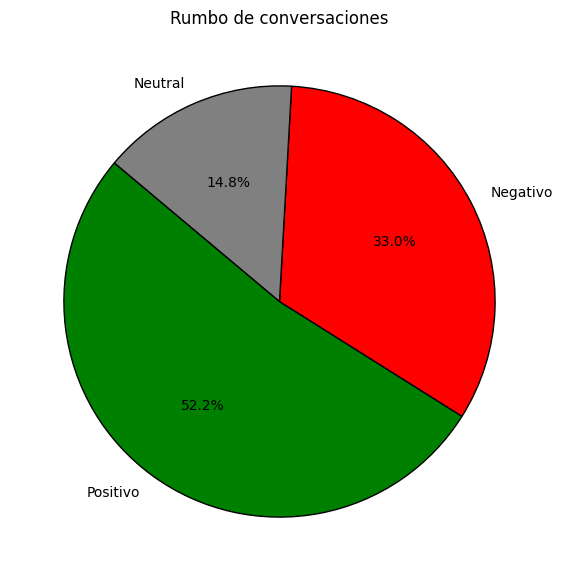

In [133]:
# Definir colores para cada sentimiento
colores = {
    "Positivo": "green",
    "Negativo": "red",
    "Neutral": "gray"
}

# Crear gráfico de pastel
plt.figure(figsize=(7,7))
plt.pie(
    porcentaje_sentimientos, 
    labels=porcentaje_sentimientos.index, 
    autopct='%1.1f%%', 
    colors=[colores[label] for label in porcentaje_sentimientos.index], 
    startangle=140, 
    wedgeprops={"edgecolor": "black"}
)

# Título del gráfico
plt.title("Rumbo de conversaciones")

# Mostrar gráfico
plt.show()

In [134]:
# Formateo
print("Tiempo de respuesta promedio:",
      formatear_tiempo_en_horas_minutos(tiempo_promedio))
print("Tiempo mensual consumido por falta de apoyo:",
      f"{round((tiempo_total/43800)*100, 2)}%")
print("Puntaje promedio:", round(puntaje_promedio, 2))

Tiempo de respuesta promedio: 0h:59m
Tiempo mensual consumido por falta de apoyo: 15.71%
Puntaje promedio: 60.26
